### ***Telecom Churn Prediction***

# Importing all the required libraries

In [191]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN

***Exploratory Data Analysis***

In [192]:
# Reading CSV File
tel_churn = pd.read_csv("Telecom_Churn_Prediction.csv")

In [193]:
# Printing first few rows of the dataset
tel_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Getting Info About The Variables in The Dataset

In [194]:
# Getting info of the dataset
tel_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We will check how monthly charges affects the customer churn.

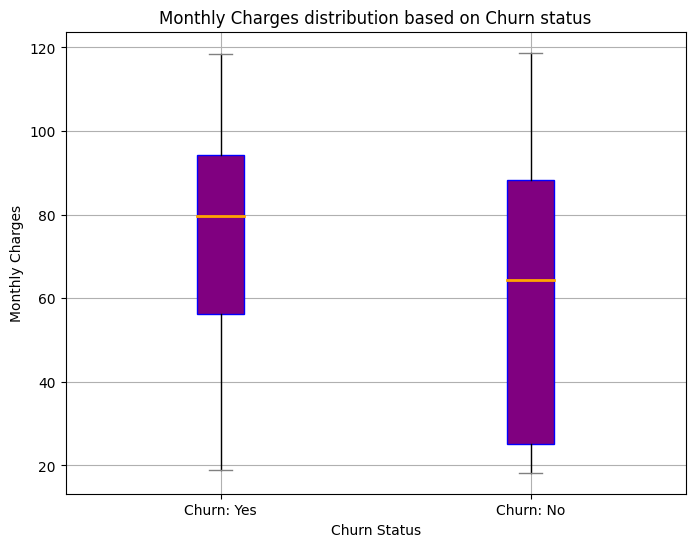

<Figure size 640x480 with 0 Axes>

In [195]:
# Separate data for churned and non-churned customers
charges_yes = tel_churn[tel_churn['Churn'] == 'Yes']['MonthlyCharges']
charges_no = tel_churn[tel_churn['Churn'] == 'No']['MonthlyCharges']

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([charges_yes, charges_no], labels=['Churn: Yes', 'Churn: No'], patch_artist=True,
            boxprops=dict(facecolor='purple', color='blue'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none'),
            medianprops=dict(color='orange', linewidth=2))

# Set labels and title
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges distribution based on Churn status')

# Show and save plot
plt.grid(True)
plt.show()
plt.savefig('MonthlyDistribution.png', bbox_inches='tight')

A visual examination of the relationship between churn and monthly charges indicates an intriguing trend. Instances of churn appear more prevalent among customers with higher monthly charges.

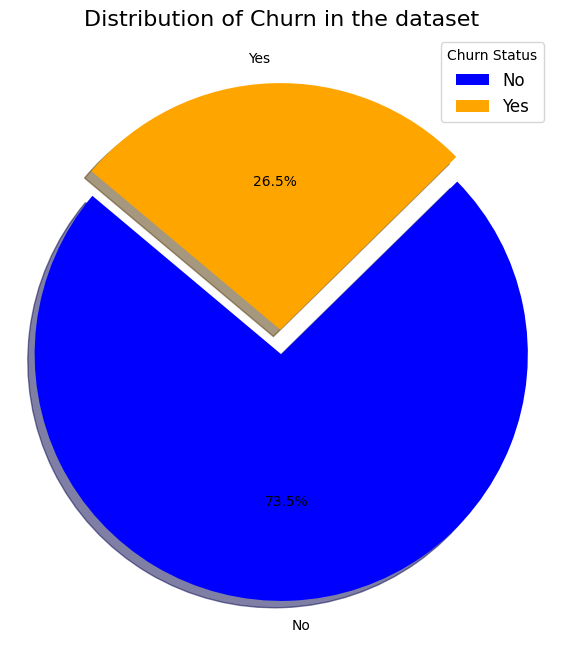

<Figure size 640x480 with 0 Axes>

In [196]:
# Get churn counts
counts = tel_churn['Churn'].value_counts()

# Create pie chart
plt.figure(figsize=(7,8))
explode = (0.1, 0)  # Explode the 'Yes' slice
colors = ['blue', 'orange']
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=140)

# Set title, legend, and axis properties
plt.title('Distribution of Churn in the dataset', fontsize=16)
plt.axis('equal')
plt.legend(title='Churn Status', loc='upper right', fontsize=12)

# Show and save plot
plt.show()
plt.savefig('ChurnDistribution.png', bbox_inches='tight')

As we can see the dataset is imbalanced, we will do the prediction first based on this imbalanced dataset and then we can do optimization for same.

Here there are many categorical data first we will find all the categorical data.
After that if there are only two categories like for 'Gender' there are male and female we can assign 0 and 1 for the same.
If there are more than two categories we can sample out the categories as different columns using oneHotEncoding.

First we will get all the categorical columns and their unique categories by running a for loop in the column and getting unique values for the same.
Also the 'TotalCharges' column which should be integer is type of object, which must be string type, we have to convert that it in numeric value.

In [197]:
#tel_churn.TotalCharges = pd.to_numeric(tel_churn.TotalCharges) It is giving error at position 488
tel_churn.iloc[488]['TotalCharges']
count_value = (tel_churn['TotalCharges'] == ' ').sum()
print(count_value)

11


As there are just 11 rows containing no values we can omit the rows, it won't affect the dataset.

In [198]:
# ommiting blank values
tel_churn = tel_churn[tel_churn["TotalCharges"].notnull() & (tel_churn["TotalCharges"] != ' ')]


In [199]:
tel_churn.shape

(7032, 21)

In [200]:
# Converting values to numeric

tel_churn.TotalCharges = pd.to_numeric(tel_churn.TotalCharges)

<ipython-input-200-3d83b7c88ef6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel_churn.TotalCharges = pd.to_numeric(tel_churn.TotalCharges)


In [201]:
# Get unique values for every single column
for column in tel_churn:
    unique_values = tel_churn[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender':
['Female' 'Male']
Unique values in column 'SeniorCitizen':
[0 1]
Unique values in column 'Partner':
['Yes' 'No']
Unique values in column 'Dependents':
['No' 'Yes']
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in column 'PhoneService':
['No' 'Yes']
Unique values in column 'MultipleLines':
['No phone service' 'No' 'Yes']
Unique values in column 'InternetService':
['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity':
['No' 'Yes' 'No internet service']
Unique values in column 'OnlineBackup':
['Yes' 'No' 'No internet service']
Unique values in column 'DeviceProtection':
['No' 'Yes' 'No internet service'

Here there are multiple yes and no columns which can be just replace with 1 and 0.

In [202]:
# Saving columns names whose values are to be replaced by by 1 and 0
YesNo_col = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']
def replaceYesNo(YesNo_col):
  for column in YesNo_col:
    tel_churn[column].replace({'Yes':1, 'No':0}, inplace = True)

replaceYesNo(YesNo_col)

tel_churn['gender'].replace({'Male':1, 'Female':0 }, inplace=True)

<ipython-input-202-663a6de792e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel_churn[column].replace({'Yes':1, 'No':0}, inplace = True)
<ipython-input-202-663a6de792e6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel_churn['gender'].replace({'Male':1, 'Female':0 }, inplace=True)


In [203]:
for column in tel_churn:
    unique_values = tel_churn[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender':
[0 1]
Unique values in column 'SeniorCitizen':
[0 1]
Unique values in column 'Partner':
[1 0]
Unique values in column 'Dependents':
[0 1]
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in column 'PhoneService':
[0 1]
Unique values in column 'MultipleLines':
['No phone service' 'No' 'Yes']
Unique values in column 'InternetService':
['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity':
['No' 'Yes' 'No internet service']
Unique values in column 'OnlineBackup':
['Yes' 'No' 'No internet service']
Unique values in column 'DeviceProtection':
['No' 'Yes' 'No internet service']
Unique values in column 'TechSu

For some Columns like 'OnlineBackup' there are values Yes, No , No Internet Service here we can replace No Internet Service with No and can convert Yes and No as 1 and 0 as we did it previously.

In [204]:
tel_churn.replace('No phone service','No',inplace=True)
tel_churn.replace('No internet service','No',inplace=True)

In [205]:
for column in tel_churn:
    unique_values = tel_churn[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender':
[0 1]
Unique values in column 'SeniorCitizen':
[0 1]
Unique values in column 'Partner':
[1 0]
Unique values in column 'Dependents':
[0 1]
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in column 'PhoneService':
[0 1]
Unique values in column 'MultipleLines':
['No' 'Yes']
Unique values in column 'InternetService':
['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity':
['No' 'Yes']
Unique values in column 'OnlineBackup':
['Yes' 'No']
Unique values in column 'DeviceProtection':
['No' 'Yes']
Unique values in column 'TechSupport':
['No' 'Yes']
Unique values in column 'StreamingTV':
['No' 'Yes']
Unique value

Now we can again replace Yes and no values by 0 and 1

In [206]:
# Now we will replace Yes and No with 1 and 0
New_Col = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
replaceYesNo(New_Col)

In [207]:
for column in tel_churn:
    unique_values = tel_churn[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender':
[0 1]
Unique values in column 'SeniorCitizen':
[0 1]
Unique values in column 'Partner':
[1 0]
Unique values in column 'Dependents':
[0 1]
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in column 'PhoneService':
[0 1]
Unique values in column 'MultipleLines':
[0 1]
Unique values in column 'InternetService':
['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity':
[0 1]
Unique values in column 'OnlineBackup':
[1 0]
Unique values in column 'DeviceProtection':
[0 1]
Unique values in column 'TechSupport':
[0 1]
Unique values in column 'StreamingTV':
[0 1]
Unique values in column 'StreamingMovies':
[0 1]
Uniqu

For other features of dataset containing multiple categorical values we can do oneHotEncoding and seperate out the values and will contain 1 for presence of that value and 0 for absence of it. For this we will use get_dummies().

In [208]:
# Performing One Hot Encoding
One_Hot = pd.get_dummies(tel_churn, columns=['Contract','PaymentMethod','InternetService'])
tel_churn_cleaned = pd.concat([tel_churn,One_Hot], axis = 1)
tel_churn_cleaned = tel_churn_cleaned.drop(['Contract','PaymentMethod','InternetService'],axis=1)

In [209]:
tel_churn_cleaned.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,1,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,1,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In above dataset we don't need 'customerID' column so we will just drop that column

In [210]:
# Dropping customerID column
tel_churn_clean = tel_churn_cleaned.drop(columns=["customerID"])

Our Target Varialble is Churn

We will have to drop one Churn column as it is duplicate of the other

In [211]:
# Dropping duplicate Churn column
tel_churn_clean = tel_churn_clean.loc[:,~tel_churn_clean.columns.duplicated()]

In [212]:
y = tel_churn_clean['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

So Now as our Cleaning is done we can start with modeling part

### **Modeling**

First we will store all the input features in X and target in Y, For our X variable we need all the columns other than our target column 'Churn'

In [213]:
X = tel_churn_clean.drop('Churn',axis=1)
Y = tel_churn_clean['Churn']

Train and Test Split

In [214]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

# Decision Tree Classifier

In [215]:
# Initialising Decision Tree Classifier
DTC = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=10)

In [216]:
# Fitting our model
DTC.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=100)

In [217]:
# Predicting based on X_test
Y_pred=DTC.predict(X_test)
print(classification_report(Y_test, Y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1026
           1       0.64      0.47      0.54       381

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.77      1407



Here as the Dataset is Imbalanced It was certain to get low accuracy, But even if we look at Recall and F-1 Score it is low or the minority class.
We will use SMOTEENN wich is use to handle imbalanced datasets by combining oversampling and undersampling techniques.

In [218]:
# Initialising SMOTEENN
smtn = SMOTEENN(random_state = 50)
# Getting new resampled data
X_New, Y_New = smtn.fit_resample(X_train,Y_train)
# Train Test Split
xr_train,xr_test,yr_train,yr_test=train_test_split(X_New, Y_New,test_size=0.2)

We will fit this data in our Decision Tree Classifier

In [219]:
# Initialising Decision Tree Classifier
DTC_New= DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=10)
DTC_New.fit(xr_train,yr_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=100)

In [220]:
# Predicting based on new resampled data
Y_pred_DTC = DTC_New.predict(xr_test)
model_score_DTC = DTC_New.score(xr_test,yr_test)
print(classification_report(yr_test,Y_pred_DTC))
print(model_score_DTC)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       425
           1       0.90      0.95      0.93       502

    accuracy                           0.92       927
   macro avg       0.92      0.91      0.92       927
weighted avg       0.92      0.92      0.92       927

0.9169363538295577


This was done using hardcoded parameters for decision tree now lets optimize it by using grid search cross validation.

In [221]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [5, 10, 15]
}

# Initializing a Decision Tree
DTC_New_CV = DecisionTreeClassifier(random_state=100)

# Create GridSearchCV for 5 fold
grid_search_DTC = GridSearchCV(estimator=DTC_New_CV, param_grid=parameters, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_DTC.fit(xr_train, yr_train)

# Retrieve the best parameters and best estimator
best_params = grid_search_DTC.best_params_
best_estimator = grid_search_DTC.best_estimator_

# Use the best estimator for prediction
yr_pred_cv = best_estimator.predict(xr_test)
print(best_params)
print(best_estimator)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=100)


In [222]:
# Getting Model Score
model_score_DTC_CV = grid_search_DTC.score(xr_test,yr_test)
print(classification_report(yr_test,yr_pred_cv))
print("Model Score : ",model_score_DTC_CV)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       425
           1       0.94      0.94      0.94       502

    accuracy                           0.93       927
   macro avg       0.93      0.93      0.93       927
weighted avg       0.93      0.93      0.93       927

Model Score :  0.9331175836030206


As we are using classification algorithms we should focus on sensitivity and specificity.

In [223]:
# Confusion Matriv
confusionMatrixDtc = confusion_matrix(yr_test,yr_pred_cv)
print(confusionMatrixDtc)

[[394  31]
 [ 31 471]]


In [224]:
TN = confusionMatrixDtc[0, 0]
FP = confusionMatrixDtc[0, 1]
FN = confusionMatrixDtc[1, 0]
TP = confusionMatrixDtc[1, 1]

# Sensitivity (Recall)
sensitivityDTC = TP / (TP + FN)
# Specificity
specificityDTC = TN / (TN + FP)
print("Sensitivity : ",sensitivityDTC)
print("Specificity : ",specificityDTC)


Sensitivity :  0.9382470119521913
Specificity :  0.9270588235294117


Now we get Better results as compared  to before, we can use SMOTEENN resampled data and Grid Search Cross validation for
other classifiers too.

# Random Forest Classifier

As we saw when we work with imbalanced dataset we get low scores, So for working with other Classifiers we will use the resampled data which we got using SMOOTEENN. For optimized classifier we can again do grid search cross validation and get best weigts for the paramenters.

In [225]:
# Giving diffrent parameters value for the classifier
parameters_RFC = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [226]:
# Initializing Random Forest Classifier
RFC = RandomForestClassifier(random_state=100)

In [227]:
# Calling GridSearchCV()
grid_search_RFC = GridSearchCV(estimator=RFC, param_grid=parameters_RFC, cv=5, scoring='accuracy')

In [228]:
grid_search_RFC.fit(xr_train, yr_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [229]:
# Storing best parameters and estimators
best_params_RFC = grid_search_RFC.best_params_
best_estimator_RFC = grid_search_RFC.best_estimator_
print(best_params_RFC)
print(best_estimator_RFC)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=100)


In [230]:
# Predicting for xr_test
yr_pred_RFC = best_estimator_RFC.predict(xr_test)

In [231]:
# Getting Classification report and model score
model_score_RFC = grid_search_RFC.score(xr_test,yr_test)
print(classification_report(yr_test,yr_pred_RFC))
print("Model Score : ",model_score_RFC)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       425
           1       0.94      0.96      0.95       502

    accuracy                           0.95       927
   macro avg       0.95      0.95      0.95       927
weighted avg       0.95      0.95      0.95       927

Model Score :  0.9471413160733549


In [232]:
# Confusion Matrix
confusionMatrixRFC = confusion_matrix(yr_test,yr_pred_RFC)
print(confusionMatrixRFC)

[[396  29]
 [ 20 482]]


In [233]:
# Calculating Sensitivity and Specificity
TN = confusionMatrixRFC[0, 0]
FP = confusionMatrixRFC[0, 1]
FN = confusionMatrixRFC[1, 0]
TP = confusionMatrixRFC[1, 1]

# Sensitivity (True Positive Rate or Recall)
sensitivityRFC = TP / (TP + FN)
# Specificity
specificityRFC = TN / (TN + FP)
print("Sensitivity : ",sensitivityRFC)
print("Specificity : ",specificityRFC)

Sensitivity :  0.9601593625498008
Specificity :  0.9317647058823529


We get good better for sensitivity and Specificity as compared to decision trees.

### XGBoost

In [234]:
# Initialising XGBoost Model
XGBoost = xgb.XGBClassifier(random_state=100)

In [235]:
# Giving parameters for the model
parameters_XGB = {
    'learning_rate': [0.1,0.3,0.01],
    'max_depth': [4,6,8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

In [236]:
# Calling GridSearchCV function
grid_search_XGB = GridSearchCV(estimator=XGBoost, param_grid=parameters_XGB, cv=5, scoring='accuracy')

In [237]:
# Fitting our model
grid_search_XGB.fit(xr_train, yr_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=100, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.3, 0.01],
                         'max_depth': [4, 6, 8],
                         'min_child_weight': [1, 3, 5]},
             scoring='accuracy')

In [238]:
# Storing Best parameters for the model
best_params_XGB = grid_search_XGB.best_params_
best_estimator_XGB = grid_search_XGB.best_estimator_
print(best_params_XGB)
print(best_estimator_XGB)

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 1}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)


In [239]:
yr_pred_XGB = best_estimator_XGB.predict(xr_test)

In [240]:
# Getting Classification report and model score
model_score_XGB = grid_search_XGB.score(xr_test,yr_test)
print(classification_report(yr_test,yr_pred_XGB))
print("Model Score : ",model_score_XGB)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       425
           1       0.96      0.96      0.96       502

    accuracy                           0.96       927
   macro avg       0.96      0.96      0.96       927
weighted avg       0.96      0.96      0.96       927

Model Score :  0.9611650485436893


In [241]:
# Confusion Matrix
confusionMatrixXGB = confusion_matrix(yr_test,yr_pred_XGB)
print(confusionMatrixXGB)

[[407  18]
 [ 18 484]]


In [242]:
# Calculating Sensitivity and Specificity
TN = confusionMatrixXGB[0, 0]
FP = confusionMatrixXGB[0, 1]
FN = confusionMatrixXGB[1, 0]
TP = confusionMatrixXGB[1, 1]

# Sensitivity (True Positive Rate or Recall)
sensitivityXGB = TP / (TP + FN)
# Specificity
specificityXGB = TN / (TN + FP)
print("Sensitivity : ",sensitivityXGB)
print("Specificity : ",specificityXGB)

Sensitivity :  0.9641434262948207
Specificity :  0.9576470588235294


## Logistic Regression

We will use logistic regression for classification, here we will use L2 regularization by setting penalty as 'l2'.

In [243]:
# Initialising The Model
LR = LogisticRegression(max_iter=1000, random_state=50)

In [244]:
# Giving Parameter to our model
parameters_LR = {
    'C': [0.001,0.1,1,10],
    'penalty': ['l2'], # Using ridge regression
    'solver': ['liblinear','saga']
}

In [245]:
# Calling GridSearchCV function
grid_search_LR = GridSearchCV(estimator=LR, param_grid=parameters_LR, cv=5, scoring='accuracy')

In [246]:
grid_search_LR.fit(xr_train, yr_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=50),
             param_grid={'C': [0.001, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [247]:
# Storing best parameters
best_params_LR = grid_search_LR.best_params_
best_estimator_LR = grid_search_LR.best_estimator_
print(best_params_LR)
print(best_estimator_LR)

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=1, max_iter=1000, random_state=50, solver='liblinear')


In [248]:
yr_pred_LR = best_estimator_LR.predict(xr_test)

In [249]:
# Getting Classification report and model score
model_score_LR = grid_search_LR.score(xr_test,yr_test)
print(classification_report(yr_test,yr_pred_LR))
print("Model Score : ",model_score_LR)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       425
           1       0.95      0.95      0.95       502

    accuracy                           0.94       927
   macro avg       0.94      0.94      0.94       927
weighted avg       0.94      0.94      0.94       927

Model Score :  0.9439050701186623


In [250]:
# Confusion Matrix
confusionMatrixLR = confusion_matrix(yr_test,yr_pred_LR)
print(confusionMatrixLR)

[[399  26]
 [ 26 476]]


In [251]:
# Calculating Sensitivity and Specificity
TN = confusionMatrixLR[0, 0]
FP = confusionMatrixLR[0, 1]
FN = confusionMatrixLR[1, 0]
TP = confusionMatrixLR[1, 1]

# Sensitivity (True Positive Rate or Recall)
sensitivityLR = TP / (TP + FN)
# Specificity
specificityLR = TN / (TN + FP)
print("Sensitivity : ",sensitivityLR)
print("Specificity : ",specificityLR)

Sensitivity :  0.9482071713147411
Specificity :  0.9388235294117647


Plotting the Sensitivity and Specificity of all the models to compare them, As we are using classification Algorithm we will focus on Sensitivity and Specificity

In [252]:
# First we will store all the values for all four algorithm.
models = ['Decision Tree', 'Random Forest Classifier','XG Boost','Logistic Rgression']
sensitivity = [sensitivityDTC, sensitivityRFC, sensitivityXGB, sensitivityLR]
specificity = [specificityDTC, specificityRFC, specificityXGB, specificityLR]

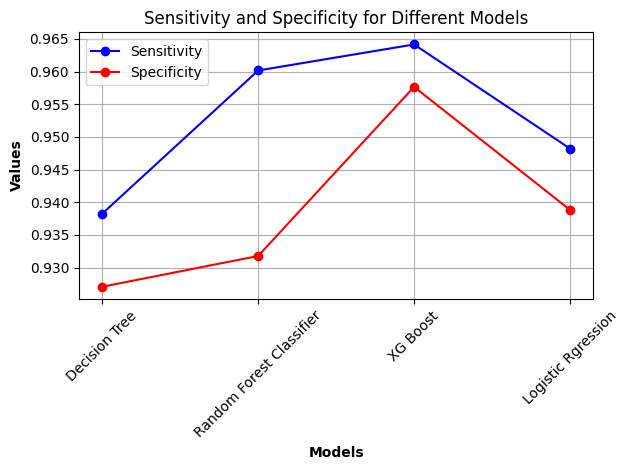

In [253]:
# Plot sensitivity values
plt.plot(models, sensitivity, marker='o', linestyle='-', color='blue', label='Sensitivity')

# Plot specificity values
plt.plot(models, specificity, marker='o', linestyle='-', color='red', label='Specificity')

# Add labels, title, legend, and grid
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.title('Sensitivity and Specificity for Different Models')
plt.legend()
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In our analysis, the observed values of Sensitivity and Specificity demonstrate a commendably high performance, particularly notable in the case of XG Boost, affirming its robust capability in accurately capturing both positive and negative instances within the dataset.